<a href="https://colab.research.google.com/github/lovelyoyrmia/Foedtra/blob/main/Machine%20Learning/foedtra_modelv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Foedtra Model Version 2

Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import os

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
  
# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, BatchNormalization, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

## Load dataset

In [ ]:
root_path = '/content/drive/MyDrive/Capstone Project - Foedtra'
labels = os.path.join(root_path, 'new_df', 'train_images.xlsx')
sample = os.path.join(root_path, 'new_df', 'test_images.xlsx')

train_path = os.path.join(root_path, 'dataset', 'train')
test_path = os.path.join(root_path, 'dataset','test')

In [ ]:
def rename_path_images(name, labels, dirs):
  return os.path.join(os.path.join('/content/drive/MyDrive/Capstone Project - Foedtra/dataset', dirs, labels), name)

In [ ]:
train_df = pd.read_excel(labels)
test_df = pd.read_excel(sample)
dev_df = pd.read_excel(os.path.join(root_path, 'new_df','dev_images.xlsx'))

In [ ]:
train_df['Filepath'] = train_df.apply(lambda x: rename_path_images(x['Filepath'], x['Label'], 'train'), axis=1)
test_df['Filepath'] = test_df.apply(lambda x: rename_path_images(x['Filepath'], x['Label'], 'test'), axis=1)

In [ ]:
print('Train has {} classes'.format(len(list(train_df['Label'].unique()))))
print('Test has {} classes'.format(len(list(test_df['Label'].unique()))))

Train has 34 classes
Test has 34 classes


## Image augmentation

In [ ]:
train_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
)

test_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
)

In [ ]:
train_images = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
)

Found 920 validated image filenames belonging to 34 classes.
Found 230 validated image filenames belonging to 34 classes.
Found 331 validated image filenames belonging to 34 classes.


## Modeling

**Mobilenetv2 Architecture**

![Mobilenetv2 Architecture](https://www.researchgate.net/publication/342856036/figure/fig3/AS:911929400885251@1594432320422/The-architecture-of-the-MobileNetv2-network.ppm)

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [ ]:
inputs = pretrained_model.input

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(34, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

## Training Model

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=2
)

Epoch 1/2
29/29 [==============================] - 103s 3s/step - loss: 1.8727 - accuracy: 0.6109 - val_loss: 0.3376 - val_accuracy: 0.9652
Epoch 2/2
29/29 [==============================] - 93s 3s/step - loss: 0.0702 - accuracy: 0.9989 - val_loss: 0.0235 - val_accuracy: 1.0000


Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.998913049697876\nValidation Accuracy: 1.0')

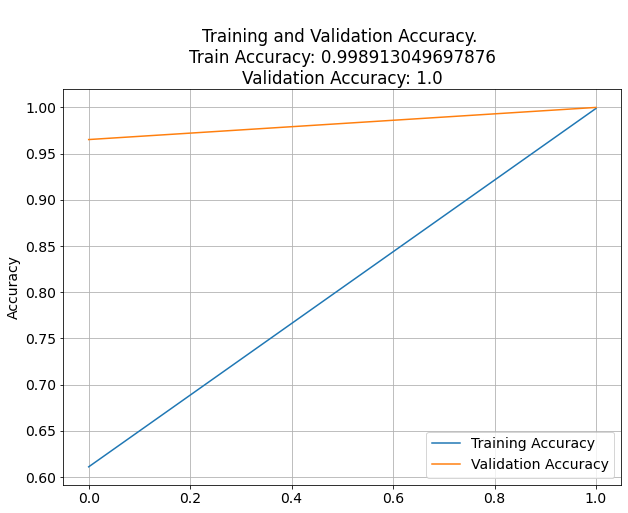

In [ ]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
  
  
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

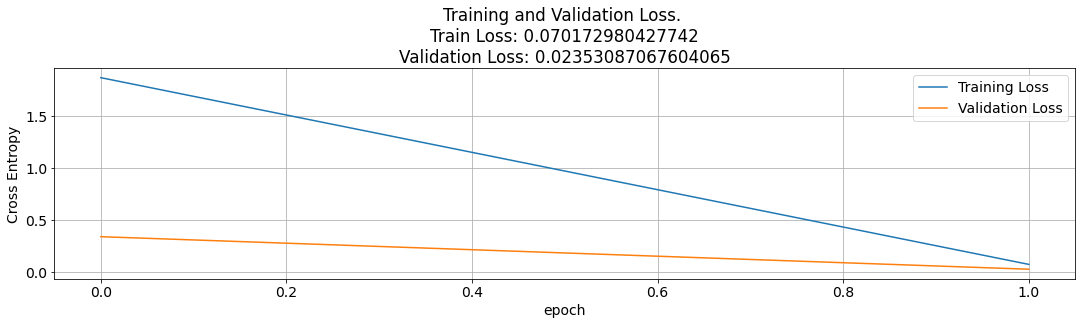

In [ ]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
accuracy_score = model.evaluate(val_images)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100)) 
  
print("Loss: ",accuracy_score[0])

8/8 [==============================] - 20s 2s/step - loss: 0.0235 - accuracy: 1.0000
[0.02353086695075035, 1.0]
Accuracy: 100.0000%
Loss:  0.02353086695075035


In [ ]:
results = model.evaluate(test_images, verbose=0)
print('Test Accuracy: {:.2f}%'.format(results[1] * 100))

Test Accuracy: 100.00%


In [ ]:
def predict_model_from_dir(class_names):
  predictions = []
    
  for image in test_df['Filepath']:
      img = tf.keras.preprocessing.image.load_img(image)
      img = tf.keras.preprocessing.image.img_to_array(img)
      img = tf.keras.preprocessing.image.smart_resize(img, (224, 224))
      img = tf.reshape(img, (-1, 224, 224, 3))
      prediction = model.predict(img/255)
      prediction = np.argmax(prediction)
      prediction = class_names[prediction]
      predictions.append(prediction)

  return predictions

class_names = list(test_images.class_indices.keys())
predictions = predict_model_from_dir(class_names)
my_submission = pd.DataFrame({'image_id': test_df['Filepath'], 'label':  predictions})
my_submission.to_excel('submission.xlsx', index=False, header=True)

In [ ]:
predicted_model = pd.read_excel('submission.xlsx')

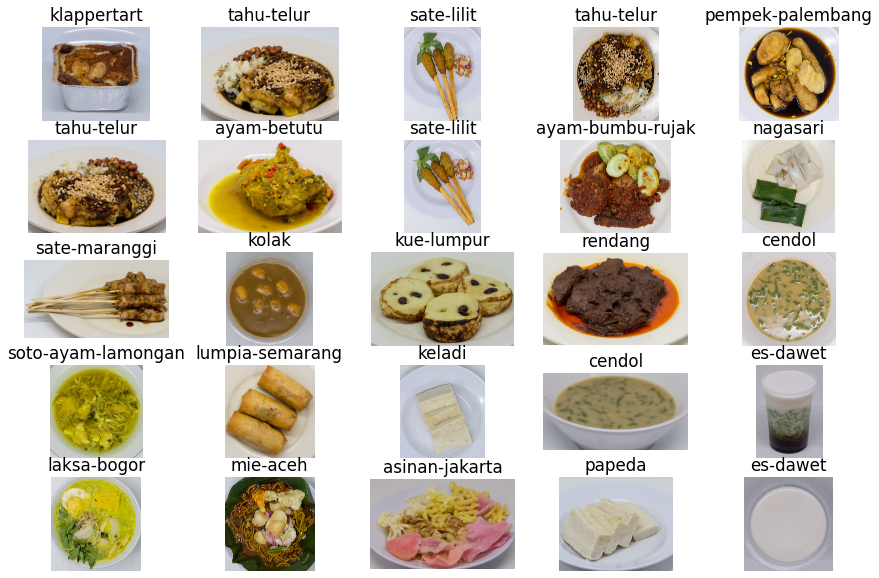

In [ ]:
plt.figure(figsize=[15,10])
for i in range(25):
  plt.subplot(5,5,i+1)
  image_test = plt.imread(predicted_model['image_id'][i])
  plt.imshow(image_test)
  plt.title(predicted_model['label'][i])
  plt.axis('off')
plt.show()

In [ ]:
def predict_image(path_image):
  img = tf.keras.preprocessing.image.load_img(path_image)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.preprocessing.image.smart_resize(img, (224, 224))
  img = tf.reshape(img, (-1, 224, 224, 3))
  prediction = model.predict(img/255)
  prediction = np.argmax(prediction)
  prediction = class_names[prediction]
  plt.title(prediction)
  img = plt.imread(path_image)
  plt.imshow(img)
  plt.show()

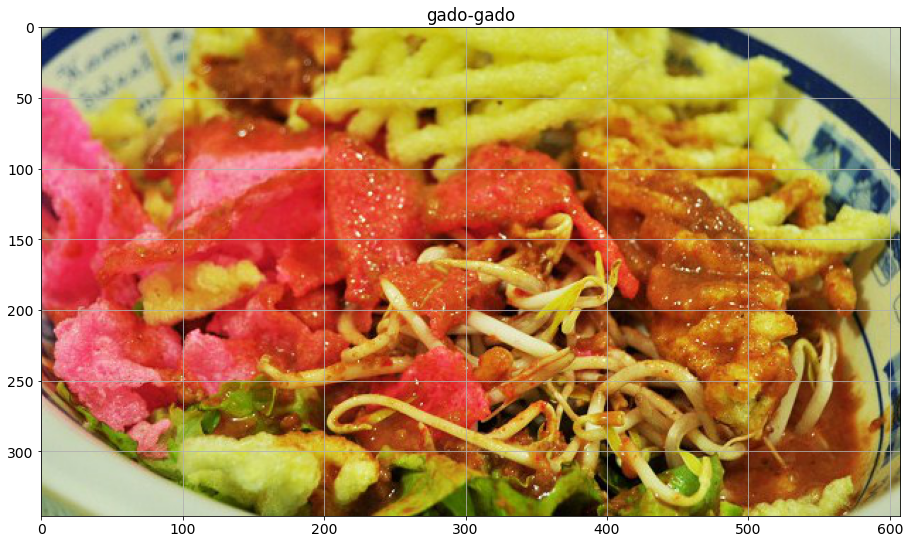

In [ ]:
predict_image('/content/anisanjakarta.jpeg')

In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)
cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions)

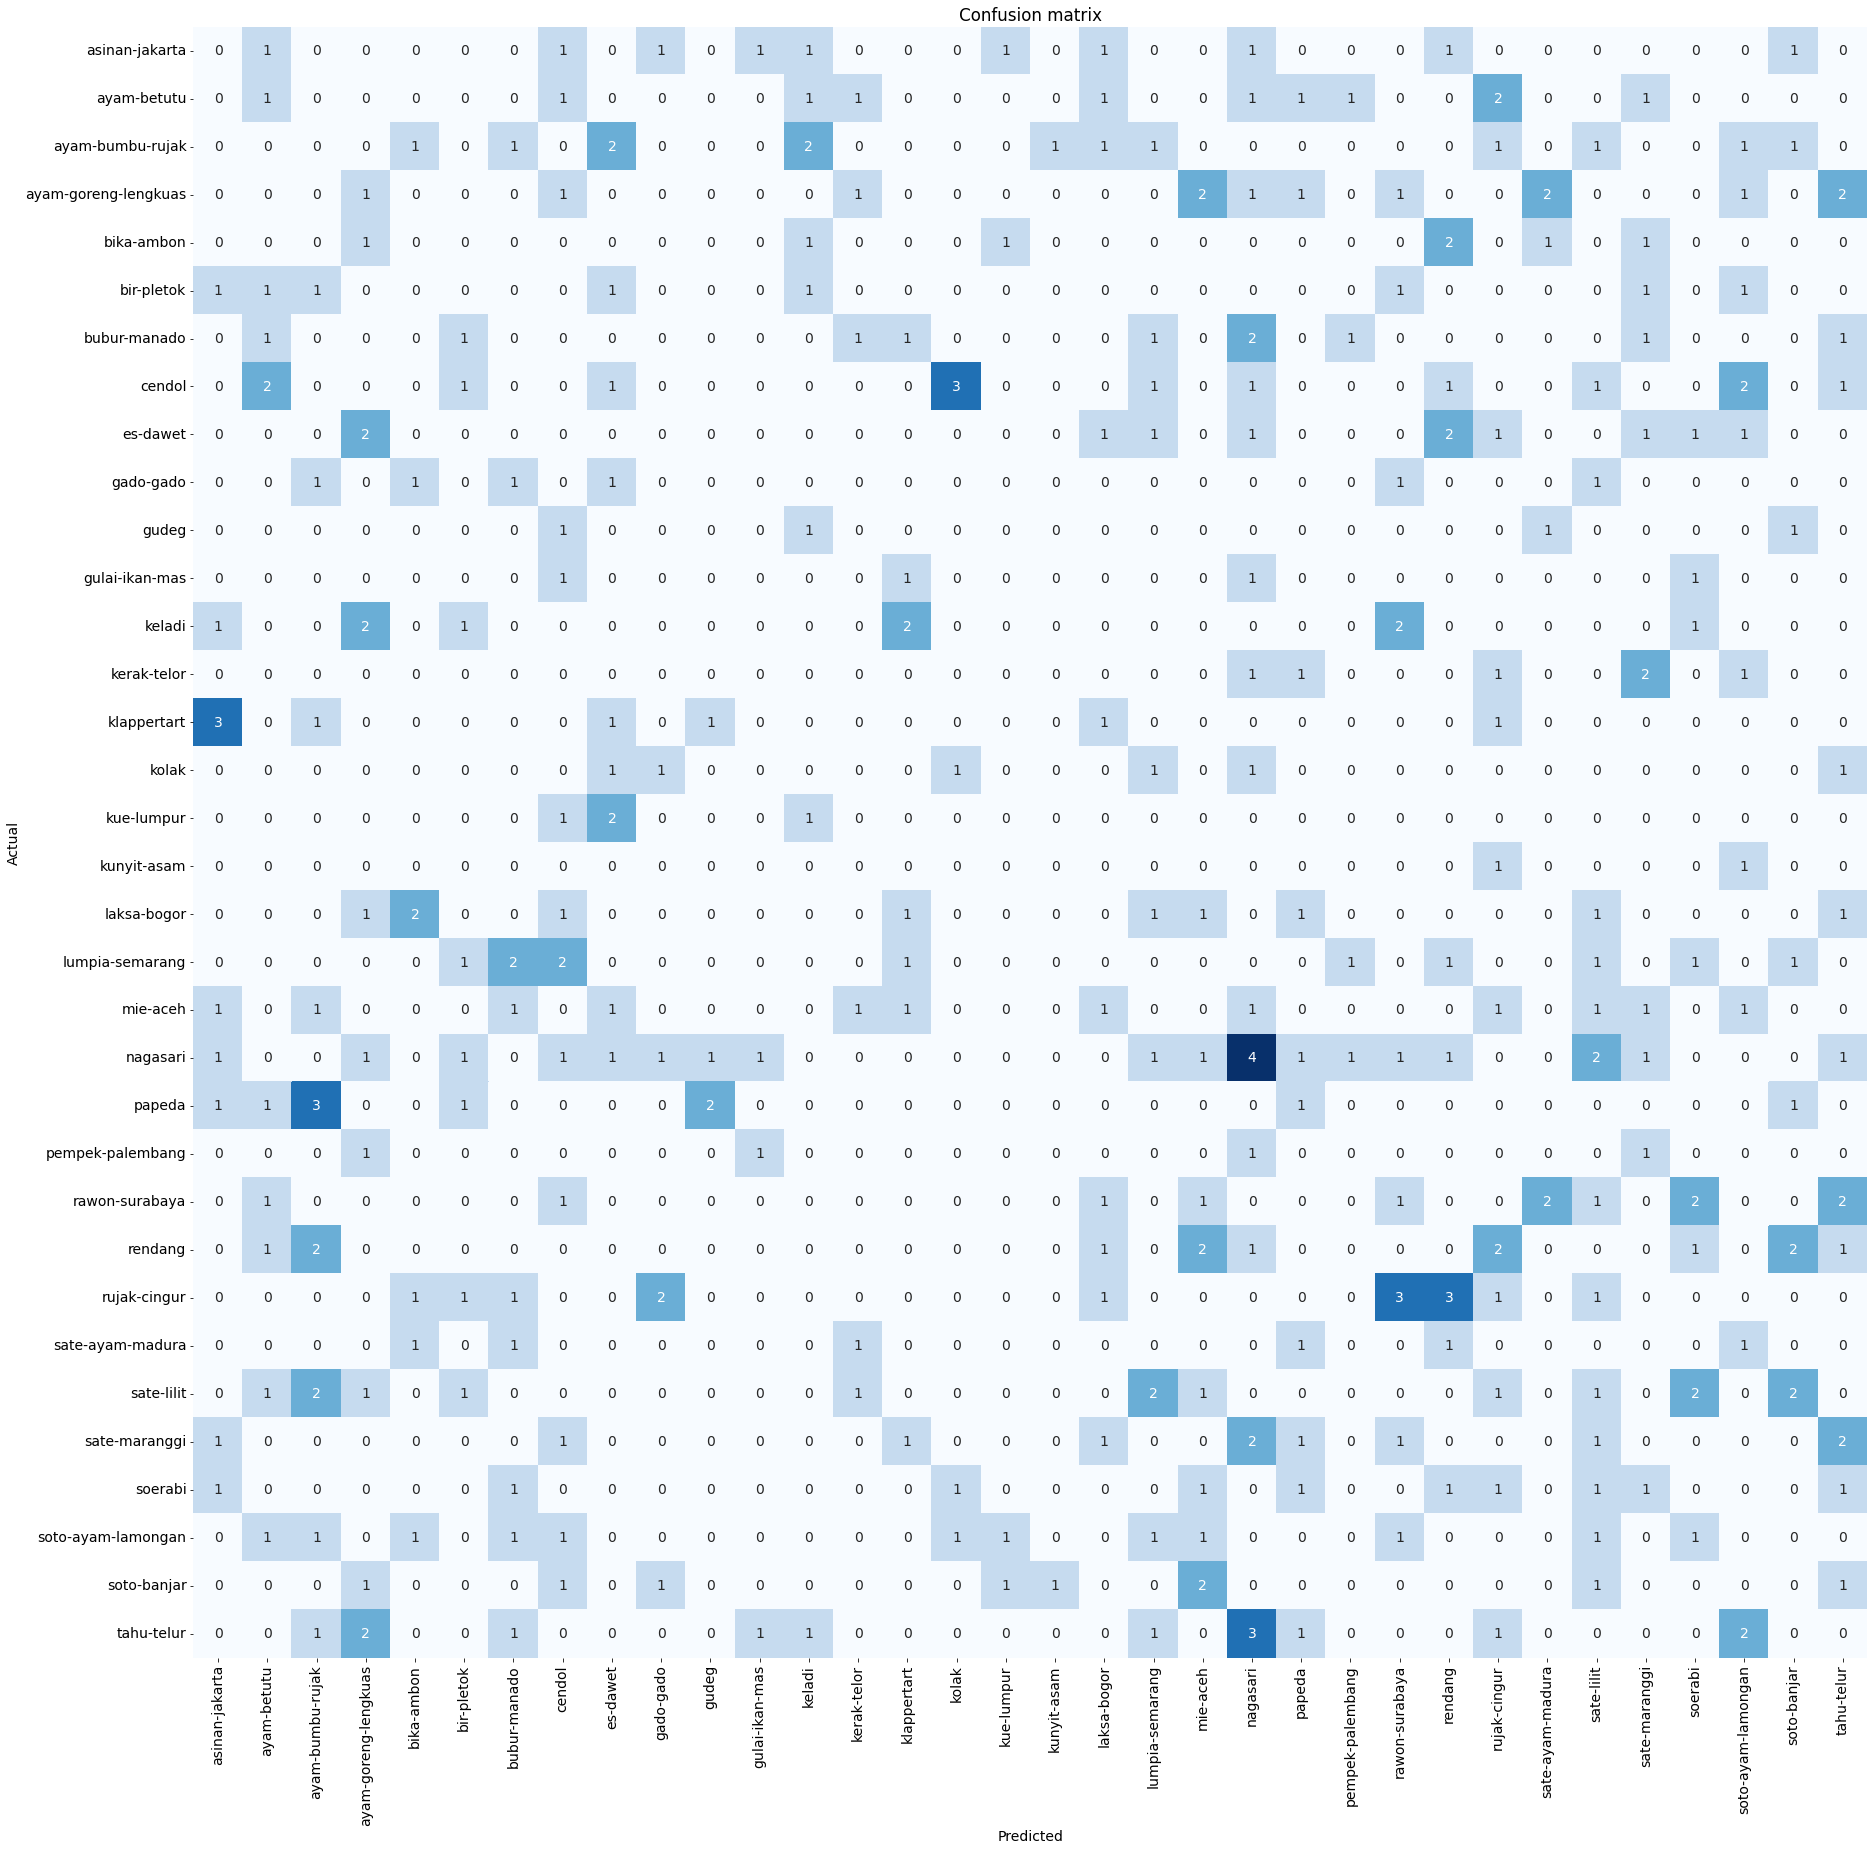

In [ ]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(34) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(34) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [ ]:
print('Classification report:\n---------------------\n', clr)

Classification report:
---------------------
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.09      0.09      0.09        11
           2       0.00      0.00      0.00        13
           3       0.08      0.08      0.08        13
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        14
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00         6
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         9
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00         8
          15       0.17      0.17      0.17         6
          16       0.00      0.00  

In [ ]:
model.save('/content/drive/MyDrive/Capstone Project - Foedtra/trained_model1/foedtra_model2.h5')